<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Run-ete3-evol-on-a-list-of-tree" data-toc-modified-id="Run-ete3-evol-on-a-list-of-tree-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Run ete3 evol on a list of tree</a></span><ul class="toc-item"><li><span><a href="#Align-nucleotide-sequences-using-amino-acids-(align-codons)" data-toc-modified-id="Align-nucleotide-sequences-using-amino-acids-(align-codons)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Align nucleotide sequences using amino-acids (align codons)</a></span></li><li><span><a href="#run-simple-model-codeML" data-toc-modified-id="run-simple-model-codeML-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>run simple model codeML</a></span></li></ul></li><li><span><a href="#Explore-results" data-toc-modified-id="Explore-results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Explore results</a></span><ul class="toc-item"><li><span><a href="#check-for-dS-saturation" data-toc-modified-id="check-for-dS-saturation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>check for dS saturation</a></span></li></ul></li><li><span><a href="#Load-sequences-and-tree" data-toc-modified-id="Load-sequences-and-tree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load sequences and tree</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Descriptive-variable" data-toc-modified-id="Descriptive-variable-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Descriptive variable</a></span></li></ul></li></ul></li><li><span><a href="#Hypothesis-testing" data-toc-modified-id="Hypothesis-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hypothesis testing</a></span><ul class="toc-item"><li><span><a href="#programatically" data-toc-modified-id="programatically-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>programatically</a></span><ul class="toc-item"><li><span><a href="#Site-models" data-toc-modified-id="Site-models-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Site models</a></span></li><li><span><a href="#Branch-site-model" data-toc-modified-id="Branch-site-model-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Branch-site model</a></span></li></ul></li><li><span><a href="#ete3-evol-tool" data-toc-modified-id="ete3-evol-tool-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>ete3 evol tool</a></span><ul class="toc-item"><li><span><a href="#Clade-model,-which-paralog-group-evolved-faster" data-toc-modified-id="Clade-model,-which-paralog-group-evolved-faster-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Clade model, which paralog group evolved faster</a></span></li></ul></li></ul></li></ul></div>

**Related documentation:**

 - command line part http://etetoolkit.org/cookbook/#Testing-evolutionary-hypothesis-(ete-evol)
 - python API: http://etetoolkit.org/docs/latest/tutorial/tutorial_adaptation.html

In [1]:
from IPython.display import display, Image

# Run ete3 evol on a list of tree

## Align nucleotide sequences using amino-acids (align codons)

For this exercice we assume you have already aligned the sequences with ete3 build using the following options"
 - use both nucleotide and aminoacids
 - trimal with automated1, we need alignment as clean as possible, CodeML is very sensible to misalignments
 
 This would be the command:
 
```
ete3 build -a fasta/$NAME.faa -n fasta/$NAME.fna --nt-switch-thr 0.0 -w mafft_default-trimal00-none-fasttree_default -o evol/$NAME -t 0.1 -c trimal00.cfg --launch-time 0.1 --nocheck --clearall --noimg -v 0```

with the config file `trimal00.cfg` such as:
```
[trimal00]
                        -automated1 = 
                               _app = trimal
                              _desc = trimal alignment cleaning removing columns with >10% gaps

```

## run simple model codeML

Next we run `ete3 evol` on each of the generated alignments (17 for this tutorial).

We run first a free-branch model, we can do so in parallel using the parallel commmand:

In [ ]:
%%bash

find data/evol -name "*.faa.final_tree.used_alg.fa" | cut -d '/' -f 2 | parallel -j 8 ete3 evol -t data/evol/{}/mafft_default-trimal00-none-fasttree_default/{}.faa.final_tree.nw --alg data/evol/{}/mafft_default-trimal00-none-fasttree_default/{}.faa.final_tree.used_alg.fa --models fb -o data/evol/{}/ --noimg --codeml_binary ~/.etetoolkit/ext_apps-latest/bin/codeml

# Explore results

## check for dS saturation

In [2]:
import os
from ete3 import EvolTree

In [3]:
rpath = 'data/evol/'

In [4]:
good_trees = []
for fam in os.listdir(rpath):
    for model in os.listdir(os.path.join(rpath, fam)):
        if not model.startswith('fb'):
            continue
        tree = EvolTree(os.path.join(rpath, fam, model, 'tree'))
        tree.link_to_evol_model(os.path.join(rpath, fam, model, 'out'), 'fb')
        if all(n.dS < 5 for n in tree.iter_descendants()): # over 5 the dS is considered saturated
            good_trees.append((len(tree), tree, fam)) # we keep length of the tree, tree object, and its nam

In [5]:
len(good_trees)

3

3 trees have trustable levels od dS:

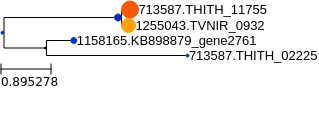

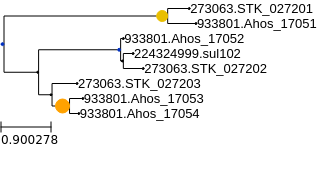

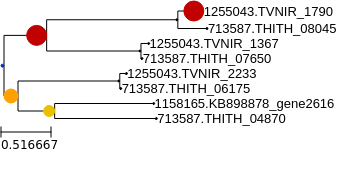

In [6]:
for _, t, _ in good_trees:
    display(t.render('%%inline'))

# Load sequences and tree

In [7]:
wanted = '933801.Ahos_17051'
fam, tree = [(n, t) for l, t, n in good_trees if n == wanted][0]

In [8]:
tree.link_to_alignment(('data/evol/{0}/mafft_default-trimal00-none-fasttree_default/'
                        '{0}.faa.final_tree.used_alg.fa').format(fam))
tree.execpath = os.path.expanduser('~') + '/eteconda/envs/etecourse/bin/ete3_apps/bin'
tree.workdir = 'data/evol/{}/'.format(fam)

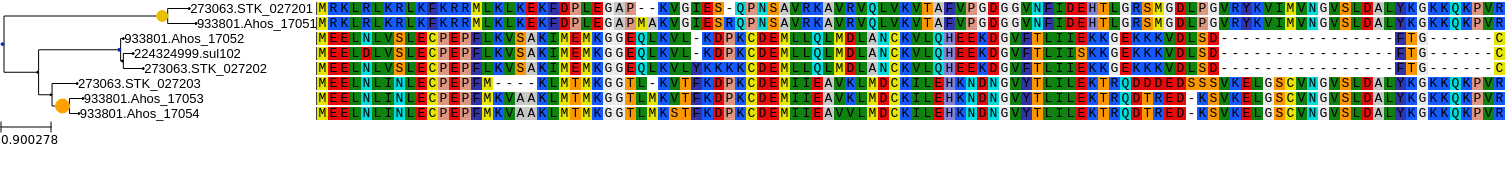

In [9]:
tree.render('%%inline')

In [10]:
tree._models

{'fb': <ete3.evol.model.Model at 0x7f474c61d828>}

### Descriptive variable

In [11]:
print(tree.get_ascii(attributes=['name', 'node_id']))


       /-273063.STK_027201, 2
   /, 10
  |    \-933801.Ahos_17051, 5
  |
-, 9       /-933801.Ahos_17052, 6
  |    /, 12
  |   |   |    /-224324999.sul102, 1
  |   |    \, 13
   \, 11       \-273063.STK_027202, 3
      |
      |    /-273063.STK_027203, 4
       \, 14
          |    /-933801.Ahos_17053, 7
           \, 15
               \-933801.Ahos_17054, 8


In [12]:
print('{:>20} {:>10} {:>8} {:>8} {:>15}'.format('Name', 'Node-id', 'dN', 'dS', 'Omega (dN/dS)'))
for n in tree.iter_descendants():
    print('{:>20} {:>10} {:8.3f} {:8.3f} {:15.3f}'.format(n.name, n.node_id, n.dN, n.dS, n.w))

                Name    Node-id       dN       dS   Omega (dN/dS)
                             10    0.929    0.834           1.113
                             11    0.000    1.463           0.000
   273063.STK_027201          2    0.000    0.925           0.000
   933801.Ahos_17051          5    0.016    1.124           0.014
                             12    0.313    1.520           0.206
                             14    0.015    0.418           0.035
   933801.Ahos_17052          6    0.000    0.080           0.000
                             13    0.000    0.032           0.000
   273063.STK_027203          4    0.001    1.077           0.001
                             15    0.024    0.000          68.623
    224324999.sul102          1    0.015    0.298           0.050
   273063.STK_027202          3    0.029    0.662           0.044
   933801.Ahos_17053          7    0.000    0.556           0.000
   933801.Ahos_17054          8    0.015    0.276           0.056


# Hypothesis testing

## programatically

### Site models

Run model of neutral evolution

In [13]:
tree.run_model('M1')

Run model incuding the possibility to evolve under positive selection

In [14]:
tree.run_model('M2')

visualize selection per sites

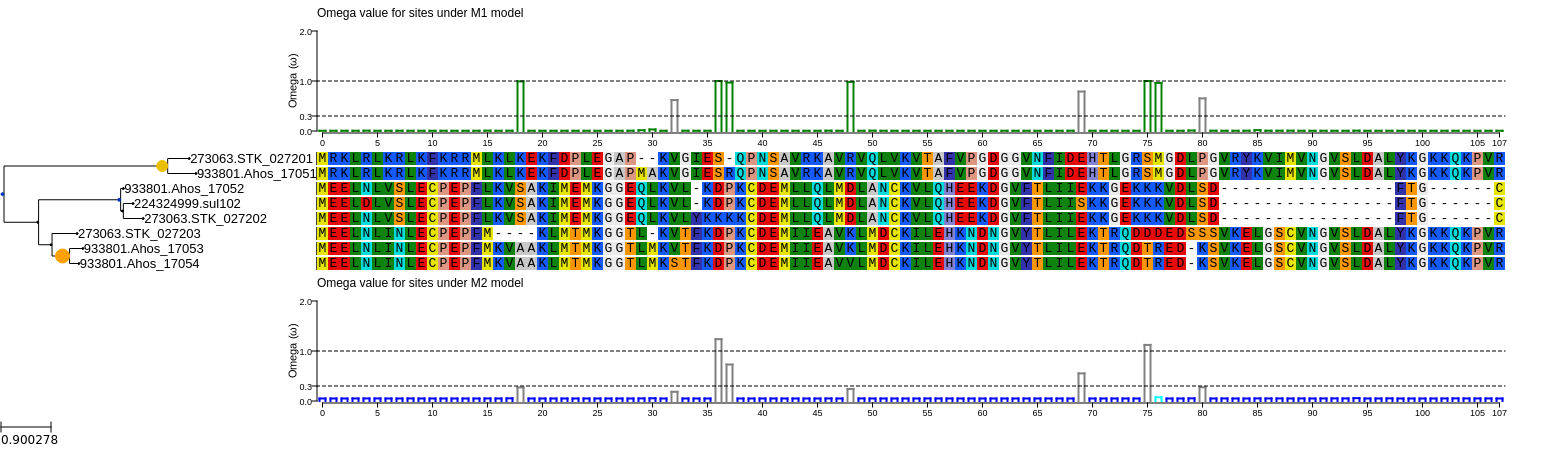

In [15]:
tree.render('%%inline', histfaces=['M1', 'M2'])

We can also modify a bit the plots

In [16]:
m1 = tree.get_evol_model('M1')
m2 = tree.get_evol_model('M2')

In [17]:
col = {'NS' : 'grey'  ,
       'RX' : 'lightgreen' ,
       'RX+': 'green' ,
       'CN' : 'cyan'  ,
       'CN+': 'blue'  ,
       'PS' : 'orange',
       'PS+': 'red'    }
m1.set_histface(up=True, colors=col)
m2.set_histface(up=True, colors=col, kind='curve', errors=True)

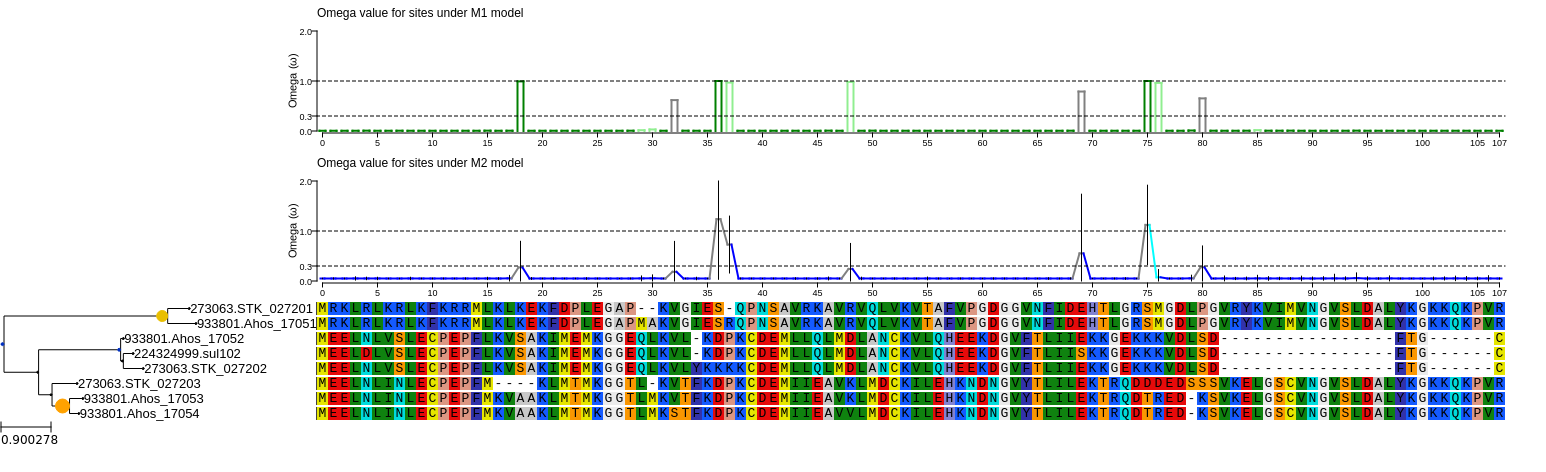

In [18]:
tree.render('%%inline', histfaces=['M1', 'M2'])

Most likely is the M1 model... no positive selection

In [19]:
tree.get_most_likely('M2', 'M1')

0.9999970000043938

### Branch-site model

We first need to tell Codeml in which branc we want to perform this test:

In [20]:
tree.search_nodes(name='224324999.sul102')[0].node_id

1

Mark the branch

In [21]:
tree.mark_tree([1], marks=['#1'])

Run two models, one for positive selection and one with omega forced to be bellow 1:

In [22]:
tree.run_model('bsA')

In [23]:
tree.run_model('bsA1')

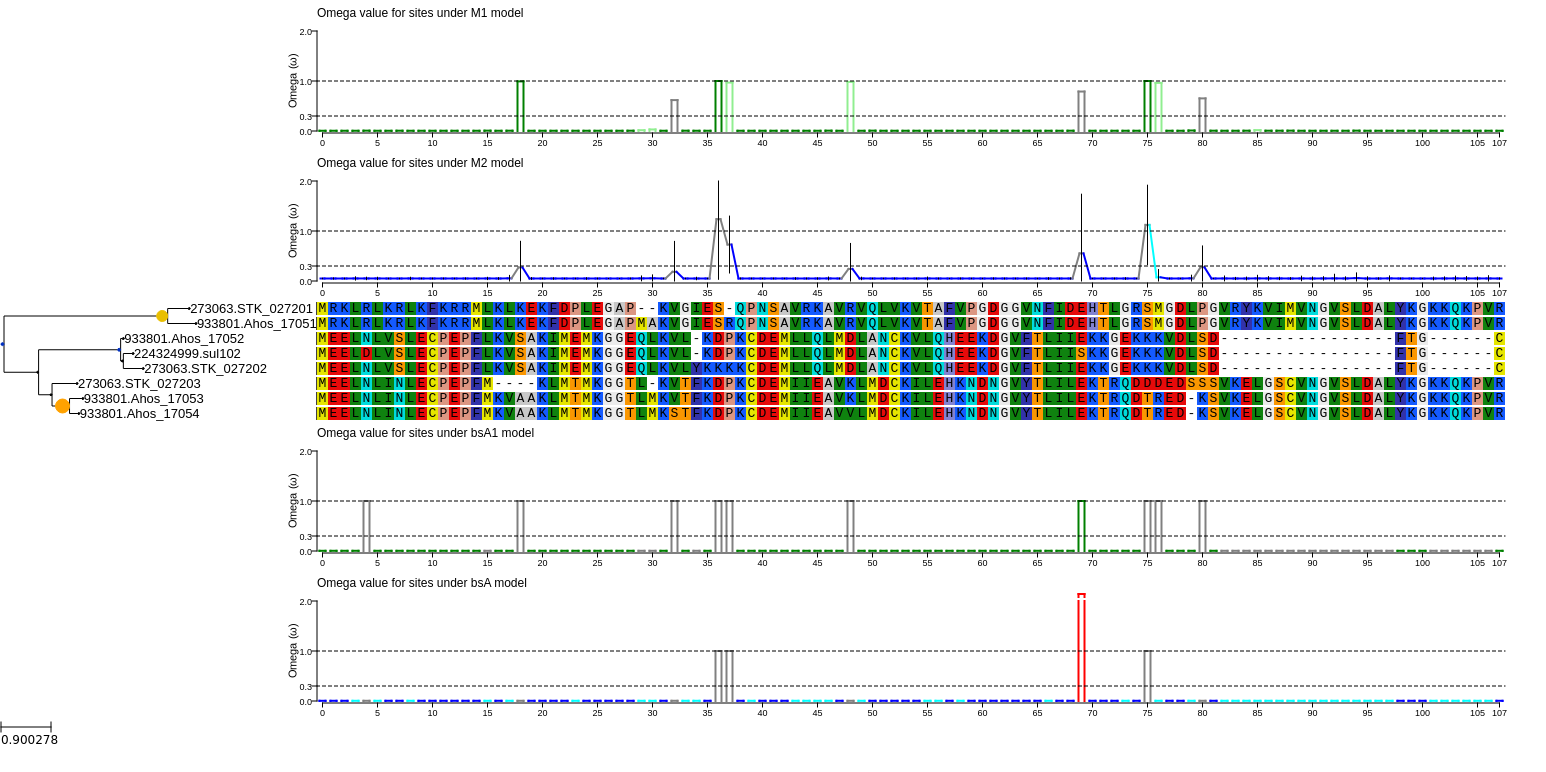

In [24]:
tree.render('%%inline', histfaces=['M1', 'M2', 'bsA1', 'bsA'])

## ete3 evol tool

All we have done can be run with:

In [25]:
%%bash

ete3 evol \
 -t data/evol/933801.Ahos_17051/mafft_default-trimal00-none-fasttree_default/933801.Ahos_17051.faa.final_tree.nw \
 --alg data/evol/933801.Ahos_17051/mafft_default-trimal00-none-fasttree_default/933801.Ahos_17051.faa.final_tree.used_alg.fa \
 -o data/evol/933801.Ahos_17051/ --cpu 4 --model bsA bsA1 M1 M2 --mark 224324999.sul102 --resume \
 -i data/evol/933801.Ahos_17051/summary_image.png

Using: /home/fransua/.miniconda3/envs/etecourse/bin/ete3_apps/bin/Slr
Using: /home/fransua/.miniconda3/envs/etecourse/bin/ete3_apps/bin/codeml

Running CodeML/Slr (4 CPUs)
  - processing model bsA (bsA~19a3f502e60ed6bb5c057f8a4511d3f8)
       marking branches 1

          ((273063.STK_027201,933801.Ahos_17051),((933801.Ahos_17052,(224324999.sul102 #1,273063.STK_027202)),(273063.STK_027203,(933801.Ahos_17053,933801.Ahos_17054))));

  - processing model bsA1 (bsA1~ae3b109ed8fe28af44fdd3701bd7b25c)
       marking branches 1

          ((273063.STK_027201,933801.Ahos_17051),((933801.Ahos_17052,(224324999.sul102 #1,273063.STK_027202)),(273063.STK_027203,(933801.Ahos_17053,933801.Ahos_17054))));

  - processing model M1 (M1~8ab0dec2ad1513c8c20a2a9a9f11cb1a)
  - processing model M2 (M2~6427e714cbf60c0722cc86e991a67f52)

LRT

                                         Null model |                             Alternative model | p-value
   =================================================|=======

/home/fransua/.miniconda3/envs/etecourse/lib/python3.6/site-packages/ete3/evol/evoltree.py:540: UserWarning: 
Large differences (> 0.1) may indicate mistaken assigantion of null and alternative models
  "\nLarge differences (> 0.1) may indicate mistaken "


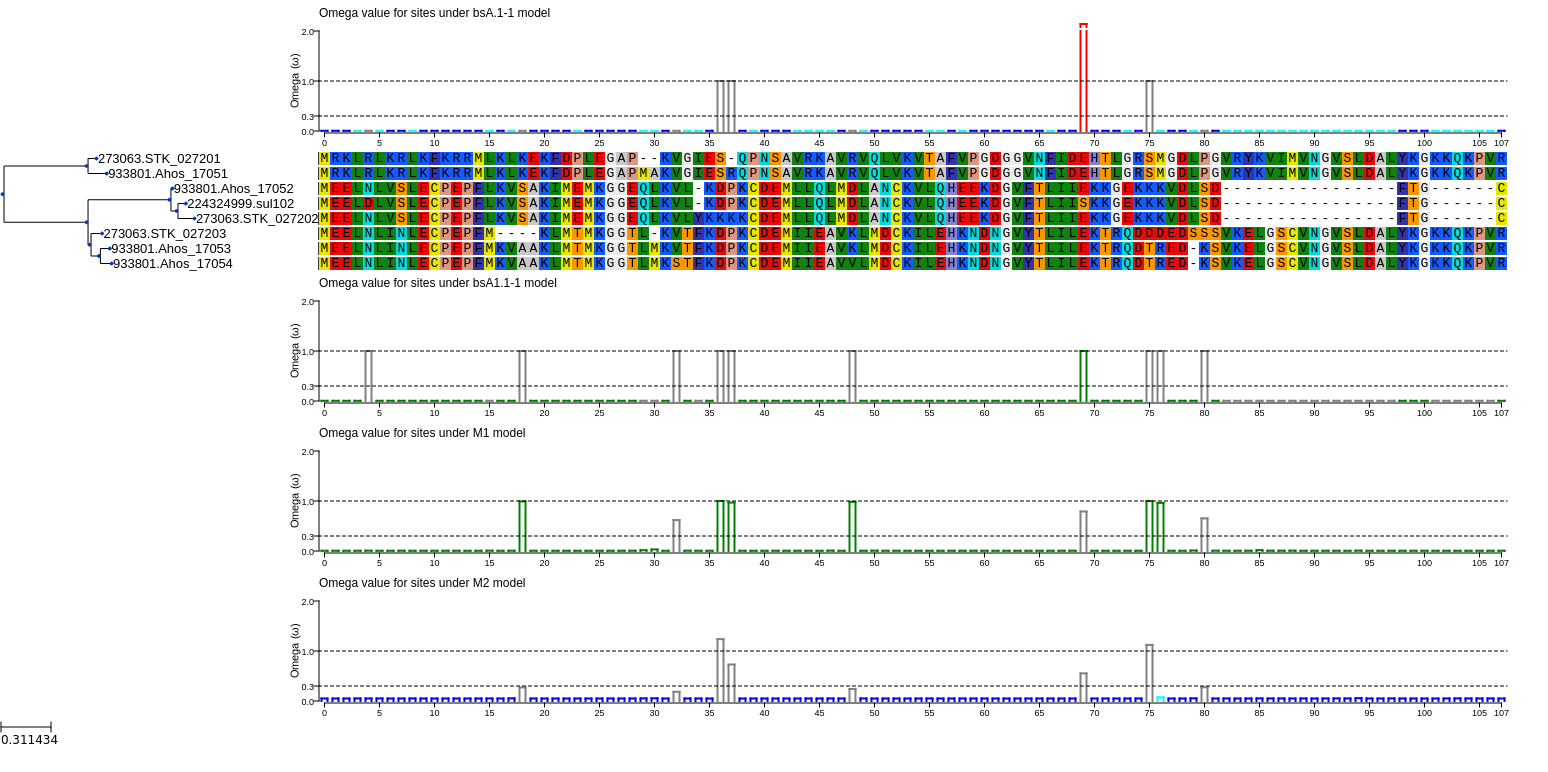

In [26]:
Image('data/evol/{}/summary_image.png'.format(wanted))

### Clade model, which paralog group evolved faster

Here we are going to use the interactive tool.

We want to mark two clades, and keep out one gene that comes from HGT
 - we mark once with all paralogs together
 - once separately

In [29]:
%%bash

ete3 evol \
 -t data/evol/933801.Ahos_17051/mafft_default-trimal00-none-fasttree_default/933801.Ahos_17051.faa.final_tree.nw \
 --alg data/evol/933801.Ahos_17051/mafft_default-trimal00-none-fasttree_default/933801.Ahos_17051.faa.final_tree.used_alg.fa \
 -o data/evol/933801.Ahos_17051/ --cpu 4 --interactive --model bsC M1 --resume

Using: /home/fransua/.miniconda3/envs/etecourse/bin/ete3_apps/bin/Slr
Using: /home/fransua/.miniconda3/envs/etecourse/bin/ete3_apps/bin/codeml

Running CodeML/Slr (4 CPUs)
  - processing model bsC (bsC~d29ee527e57137f9341a8e97bd19518d)
       marking branches 12, 14, 6, 13, 4, 15, 1, 3, 7, 8

          ((273063.STK_027201,933801.Ahos_17051),((933801.Ahos_17052  #2,(224324999.sul102  #1,273063.STK_027202  #1)  #1)  #1,(273063.STK_027203  #1,(933801.Ahos_17053  #1,933801.Ahos_17054  #1)  #1)  #1));

       marking branches 12, 14, 6, 13, 4, 15, 1, 3, 7, 8

          ((273063.STK_027201,933801.Ahos_17051),((933801.Ahos_17052  #3,(224324999.sul102  #1,273063.STK_027202  #1)  #1)  #1,(273063.STK_027203  #2,(933801.Ahos_17053  #2,933801.Ahos_17054  #2)  #2)  #2));

  - processing model M1 (M1~8ab0dec2ad1513c8c20a2a9a9f11cb1a)
Model M1 (M1~8ab0dec2ad1513c8c20a2a9a9f11cb1a) already executed... SKIPPING

LRT

                                         Null model |                             Alte

The paralog groups have significantly different evolutionary rates